In [1]:
# Install MediaPipe (if not already installed)
!pip install -q mediapipe opencv-python

In [2]:
# Instalar ffmpeg
!pip install ffmpeg-python

In [3]:
# Instalar pandas
!pip install pandas

In [4]:
# Download Pose Landmarker model
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

In [5]:
import cv2
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import ffmpeg
import pandas as pd

def draw_landmarks_on_image(rgb_image, detection_result):
    pose_landmarks_list = detection_result.pose_landmarks
    annotated_image = np.copy(rgb_image)

    # Loop through the detected poses to visualize.
    for idx in range(len(pose_landmarks_list)):
        pose_landmarks = pose_landmarks_list[idx]

        # Draw the pose landmarks.
        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
        ])
        solutions.drawing_utils.draw_landmarks(
            annotated_image,
            pose_landmarks_proto,
            solutions.pose.POSE_CONNECTIONS,
            solutions.drawing_styles.get_default_pose_landmarks_style())
    return annotated_image

# Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# Create a PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# Capture video from file or webcam
video_path = 'costadouno.mp4'  # Cambia esto por la ruta de tu video
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: No se puede abrir el video.")
    exit()

# Obtener propiedades del video original
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Establecer nuevas dimensiones para el video de salida
output_width = 800  # Cambia esto por el ancho deseado
output_height = 600  # Cambia esto por la altura deseada

# Crear un objeto VideoWriter para guardar el video procesado
output_video_path = 'output_video.mp4'
out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (output_width, output_height))

# Lista para almacenar los datos de los landmarks
landmarks_data = []

frame_idx = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Redimensionar el frame
    resized_frame = cv2.resize(frame, (output_width, output_height))

    # Convertir el frame de BGR a RGB
    rgb_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
    image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_frame)

    # Detectar los landmarks en el frame
    detection_result = detector.detect(image)

    # Dibujar los landmarks en el frame
    annotated_frame = draw_landmarks_on_image(image.numpy_view(), detection_result)

    # Convertir el frame anotado de RGB a BGR para OpenCV
    bgr_annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR)

    # Escribir el frame anotado en el video de salida
    out.write(bgr_annotated_frame)

    # Extraer y almacenar los datos de los landmarks
    if detection_result.pose_landmarks:
        for idx, landmark in enumerate(detection_result.pose_landmarks[0]):
            landmarks_data.append({
                'frame': frame_idx,
                'landmark_id': idx,
                'x': landmark.x,
                'y': landmark.y,
                'z': landmark.z
            })
    frame_idx += 1

cap.release()
out.release()

# Guardar los datos de los landmarks en un archivo CSV
landmarks_df = pd.DataFrame(landmarks_data)
landmarks_df.to_csv('landmarks_data.csv', index=False)

# Convertir el video guardado a formato compatible para mostrar en Colab
output_video_path_converted = 'output_video_converted.mp4'
ffmpeg.input(output_video_path).output(output_video_path_converted).run(overwrite_output=True)

# Mostrar el video guardado
from IPython.display import Video
Video(output_video_path_converted, embed=True)


In [6]:
# Suponiendo que landmarks_data es una lista de diccionarios como se define en el código anterior
if landmarks_data:
  head = landmarks_data[0].keys()  # Obtiene las claves del primer diccionario como encabezado
  print(head)


dict_keys(['frame', 'landmark_id', 'x', 'y', 'z'])


In [7]:
# 10 primeras filas
landmarks_df.head(10)


,frame,landmark_id,x,y,z
0,0,0,0.567340,0.235609,-0.310441
1,0,1,0.573066,0.222393,-0.290927
2,0,2,0.577807,0.222843,-0.291233
3,0,3,0.580647,0.223380,-0.291154
4,0,4,0.564699,0.221216,-0.287935
5,0,5,0.562027,0.220702,-0.288264
6,0,6,0.559809,0.220138,-0.288433
7,0,7,0.584611,0.227511,-0.167549
8,0,8,0.557082,0.224327,-0.154012
9,0,9,0.571754,0.248134,-0.261108


      frame  landmark_id         x         y         z
35        1            2  0.580264  0.224373 -0.301422
101       3            2  0.580941  0.227692 -0.269271
167       5            2  0.582839  0.237965 -0.288120
233       7            2  0.588213  0.238134 -0.235042
299       9            2  0.591073  0.241942 -0.250229
365      11            2  0.595286  0.247999 -0.232364
431      13            2  0.601817  0.261202 -0.224513
497      15            2  0.615497  0.269315 -0.253341
563      17            2  0.627833  0.287431 -0.237939
629      19            2  0.639831  0.298518 -0.375452
695      21            2  0.645696  0.296416 -0.364797
761      23            2  0.652564  0.308903 -0.349860
827      25            2  0.654614  0.316222 -0.297128
893      27            2  0.660342  0.327866 -0.344153
959      29            2  0.661761  0.334799 -0.370686
1025     31            2  0.662278  0.341463 -0.461803
1091     33            2  0.659616  0.345248 -0.414142
1157     3

<Axes: xlabel='frame'>

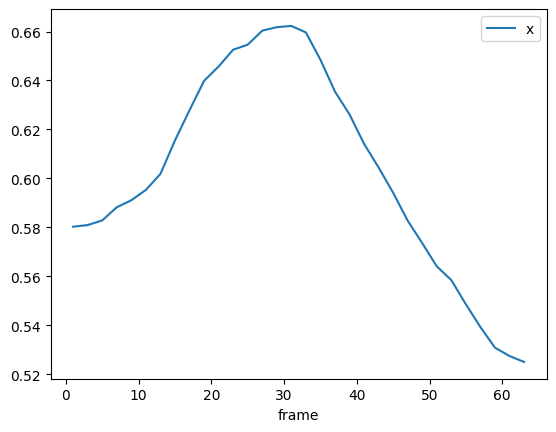

In [8]:
# Selecciona las filas que tengan frame == 0 y landmark_id == 2
selected_rows = landmarks_df[(landmarks_df['frame']) & (landmarks_df['landmark_id'] == 2)]

# Muestra las filas seleccionadas
print(selected_rows)

# graficar
selected_rows.plot(x='frame', y='x')
